# Random numbers

In this lecture we will use the numpy random library to generate some (pseudo) random numbers.

The manual page is : https://numpy.org/doc/stable/reference/random/index.html#

First we create the random number generator.

In [1]:
from numpy.random import default_rng
rng = default_rng()

In [6]:
a = rng.random()
print(a)

0.2099261008712343


In [9]:
b = rng.random(10)
print(b)

[0.85357002 0.87426662 0.18650353 0.34586282 0.21754694 0.78114501
 0.08516262 0.83911432 0.51224615 0.31966841]


In [10]:
a = rng.random(int(1e4))

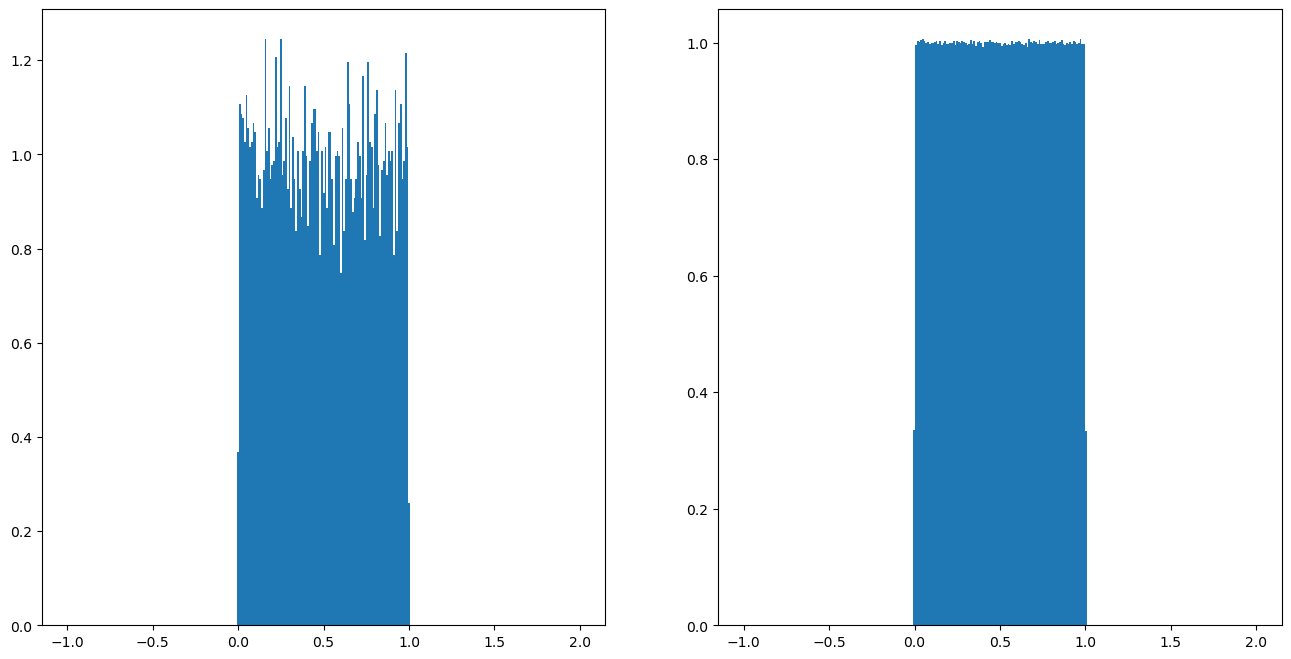

In [12]:
import numpy as np
import matplotlib.pyplot as plt

a = rng.random(int(1e4))
b = rng.random(int(1e7))

bins = np.linspace(-1, 2, 300)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,8))

ax1.hist(a, bins, density=True)
ax2.hist(b, bins, density=True)

plt.show()


# Random seeds



In [19]:
rng = default_rng(12345)

print(rng.random(10))

[0.22733602 0.31675834 0.79736546 0.67625467 0.39110955 0.33281393
 0.59830875 0.18673419 0.67275604 0.94180287]


# Other distributions



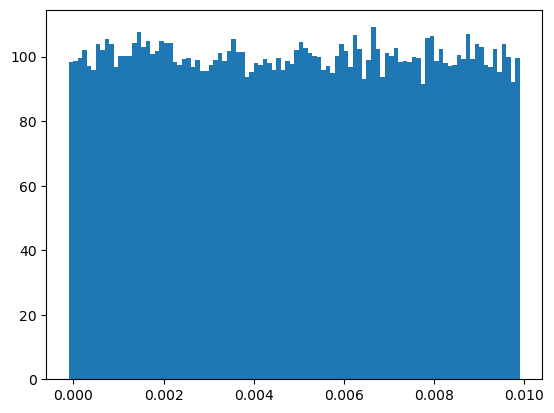

In [21]:
a = 0.01 * rng.random(int(1e5)) - 0.0001

plt.hist(a, bins=100, density=True)
plt.show()

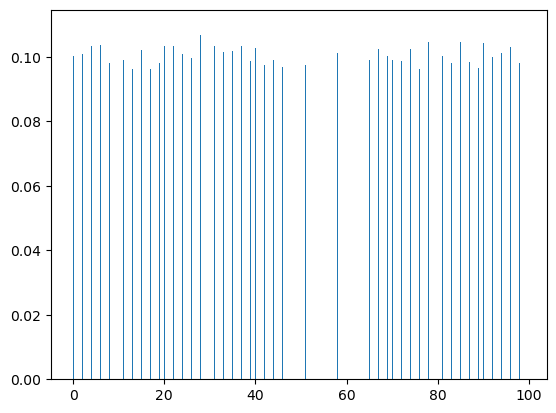

In [25]:
a = rng.integers(0, 100, size=int(1e5))

plt.hist(a, bins=1000, density=True)
plt.show()

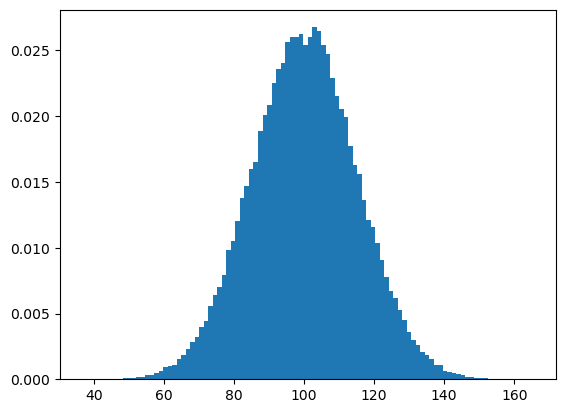

In [27]:
a = rng.normal(100, 15, size=(int(1e5)))

plt.hist(a, bins=100, density=True)
plt.show()

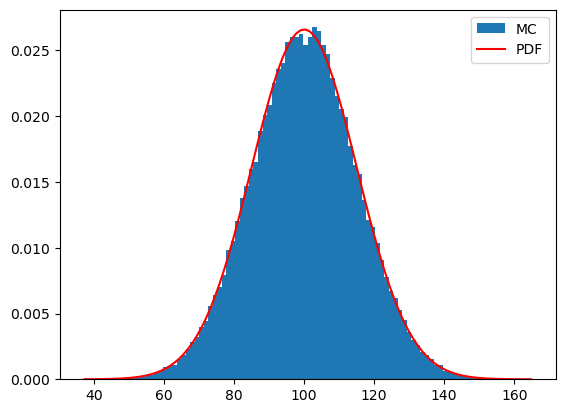

In [29]:

n, bins, patches = plt.hist(a, bins=100, density=True, label="MC")
bin_centres = (bins[1:] + bins[:-1])/2

# https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.norm.html
from scipy.stats import norm

plt.plot(bin_centres, norm.pdf(bin_centres, 100., 15), 'r', label="PDF")
plt.legend()
plt.show()

[ 85.0853436  106.33757341  77.72373625 106.41926982  99.09836976
 116.02964266  81.28389602  74.24957017 118.43849777 115.34766996]


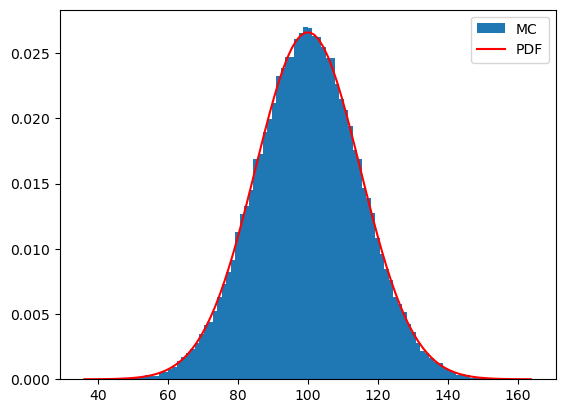

In [30]:
a = norm.rvs(100., 15., int(1e5))
print(a[0:10])

n, bins, patches = plt.hist(a, bins=100, density=True, label="MC")
bin_centres = (bins[1:] + bins[:-1])/2

plt.plot(bin_centres, norm.pdf(bin_centres, 100., 15), 'r', label="PDF")
plt.legend()
plt.show()

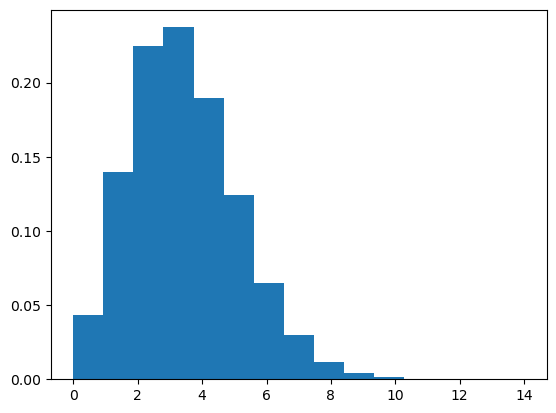

In [32]:
# Poisson

a = rng.poisson(3.2, int(1e5))
plt.hist(a, bins=15, density=True)
plt.show()

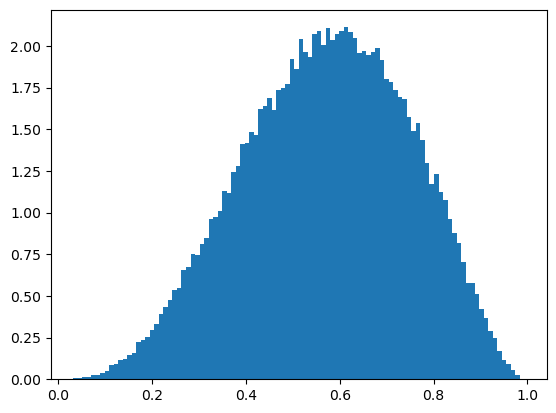

In [33]:
# beta function

from scipy.stats import beta

a = beta.rvs(4, 3, size=int(1e5))
plt.hist(a, bins=100, density=True, label="MC")
plt.show()

# Inverse Transform Method



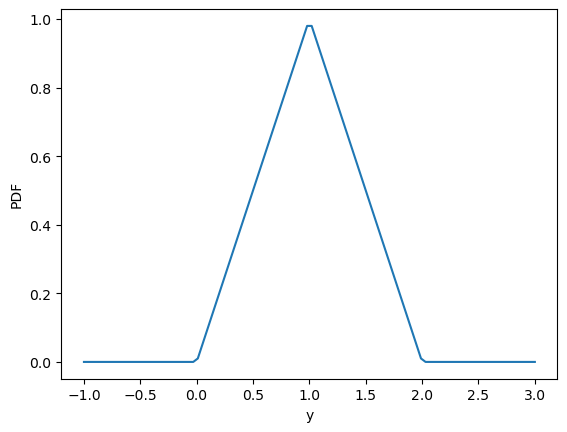

In [34]:
def triangle(x):
    tmp = np.zeros(x.shape)    
    tmp[(x > 0) & (x <= 1)] = x[(x > 0) & (x <= 1)]
    tmp[(x > 1) & (x <= 2)] = 2-x[(x > 1) & (x <= 2)]
    return tmp

x = np.linspace(-1, 3, 100)
plt.plot(x, triangle(x))
plt.xlabel('y')
plt.ylabel('PDF')
plt.show()

We have to calculate the inverse transform analytically.  This will allow us to transform a uniform distributed variable $x$ to a variable $y$ with the desired distribution.

First we need to find the CDF :

\begin{align}
Q(y) = &0 \quad &y \le 0 \\
               &\frac{y^2}{2}  \quad &0 \gt y \le 1 \\
               &1-\frac{(2-y)^2}{2} \quad &1 \gt y \le 2 \\
               &0 \quad &y \gt 2
\end{align}

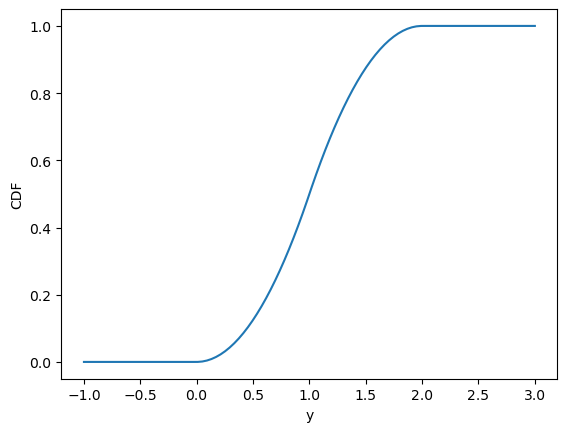

In [36]:
# just a plot of the CDF to convince ourselves it's correct
def triangle_cdf(x):
    tmp = np.zeros(x.shape)    
    tmp[(x > 0) & (x <= 1)] = 0.5*np.power(x[(x > 0) & (x <= 1)],2)
    tmp[(x > 1) & (x <= 2)] = 1-0.5*np.power(2-x[(x > 1) & (x <= 2)],2)
    tmp[x>2] = 1
    return tmp

plt.plot(x, triangle_cdf(x))
plt.xlabel('y')
plt.ylabel('CDF')
plt.show()

The inverse function is therefore :
\begin{align}
Q^{-1}(x)    = &\sqrt{2x} \quad &0 \gt x \le \frac{1}{2} \\
                   &2-\sqrt{2(1-x)} \quad &\frac{1}{2} \gt x \le 1
\end{align}

So we can convert x (generated with _rng.random_) to the desired triangle distribution, using $y=Q^{-1}(x)$.

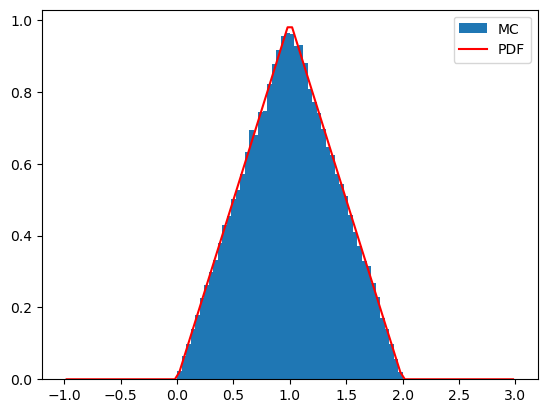

In [37]:
def inverse_cdf(x):
    tmp = np.zeros(x.shape)
    tmp[x<=0.5] = np.sqrt(2*x[x<=0.5])
    tmp[x>0.5]  = 2 - np.sqrt(2*(1-x[x>0.5]))
    return tmp

a = rng.random(int(1e5))
b = inverse_cdf(a)

n, bins, patches = plt.hist(b, bins=100, range=(-1,3), density=True, label="MC")
bin_centres = (bins[1:] + bins[:-1])/2
plt.plot(bin_centres, triangle(bin_centres), 'r', label="PDF")
plt.legend()
plt.show()

# Accept-Reject Method

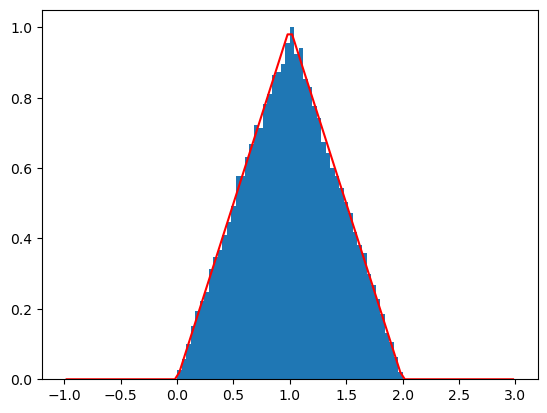

In [39]:
def triangle_ar_np(n):
    a = 2*rng.random(n)
    b = rng.random(n)
    return a[b < triangle(a)]

c = triangle_ar_np(int(1e5))

n, bins, patches = plt.hist(c, bins=100, range=(-1,3), density=True, label="MC")
bin_centres = (bins[1:] + bins[:-1])/2
plt.plot(bin_centres, triangle(bin_centres), 'r', label="PDF")
plt.show()

In [40]:
# Note this method produces fewer outputs than random numbers we originally generated
print(len(c))

49794


## Monte-Carlo Integration

We did not have time for this in the lecture, but accept-reject can be used to integrate arbitrary functions.

Effectively the accept-reject method produces points in a 2D region.  The fraction of values accepted by the method, multiplied by the total area of the 2D region over which they are generated gives us the area under the PDF.

In [43]:
frac_triangle = len(triangle_ar_np(int(1e5)))/1e5
area_tot = 2. * 1.
print("Integral of triangle() = {}".format(frac_triangle * area_tot))

Integral of triangle() = 0.99276


We can use the same technique to compute the area of a circle. Below, (x,y) are coordiantes in the 2D plane.  (x_acc, y_acc) are points which lie within the circle (ie, $x^2 + y^2 < 1$) and black poisnt are those that fail.

The area of the circle is given by the fraction of accepted points multipied by the area generated.

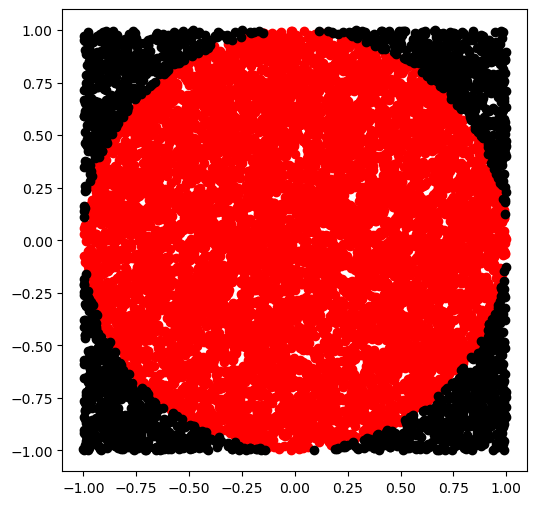

Area of the circle = 3.1324


In [49]:
x = 2*rng.random(int(1e4))-1
y = 2*rng.random(int(1e4))-1

x_acc = x[(x**2+y**2)<=1]
y_acc = y[(x**2+y**2)<=1]
x_fail = x[(x**2+y**2)>1]
y_fail = y[(x**2+y**2)>1]

fig = plt.subplots(1,1,figsize=(6,6))
plt.scatter(x_acc, y_acc, color='r')
plt.scatter(x_fail, y_fail, color='k')
plt.show()

frac = len(x_acc)/1e4
area = 4 * frac
print("Area of the circle = {}".format(area))

We can use this to write a function that will compute $\pi$ to arbitrary precision.

In [50]:
def compute_pi(n):
    a = 2*rng.random(n)-1
    b = 2*rng.random(n)-1
    aa = a[(a**2+b**2)<=1]
    return 4*len(aa)/n

In [51]:
compute_pi(int(1e9))

3.141700828